**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

/Users/tom/.local/share/virtualenvs/ml-zoomcamp-homework-UodQinw2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [3]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [4]:
df['median_house_value'] = np.log1p(df['median_house_value'])

#@ SPLITTING THE DATASET FOR TRAINING AND TEST:

df_train, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=1)

- We will use `DictVectorizer` to turn train and validation into matrices.

In [5]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(df_train.drop('median_house_value', axis=1).to_dict(orient='records'))
y_train = df_train['median_house_value']
X_val = dv.fit_transform(df_val.drop('median_house_value', axis=1).to_dict(orient='records'))
y_val = df_val['median_house_value']

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [6]:
#@ TRAINING THE REGRESSION MODEL:
from sklearn.tree import DecisionTreeRegressor, export_text

model_dt = DecisionTreeRegressor(max_depth=1)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [7]:
#@ INSPECTION:
print(export_text(model_dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/Users/tom/.local/share/virtualenvs/ml-zoomcamp-homework-UodQinw2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


- Which feature is used for splitting the data?

- Answer:

ocean_proximity=INLAND

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [8]:
#@ TRAINING RANDOM FOREST MODEL:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [9]:
#@ CALCULATING MEAN SQUARED ERROR:
from sklearn.metrics import mean_squared_error

y_pred = model_rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

round(rmse, 2)

0.25

- What's the RMSE of this model on validation?

- Answer: 

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [10]:
#@ TRAINING THE RANDOM FOREST MODEL:
res = []
for est in range(10, 201, 10):
    model_rf = RandomForestRegressor(n_estimators=est, random_state=1, n_jobs=-1)
    model_rf.fit(X_train, y_train)

    y_pred = model_rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    res.append((est, rmse))

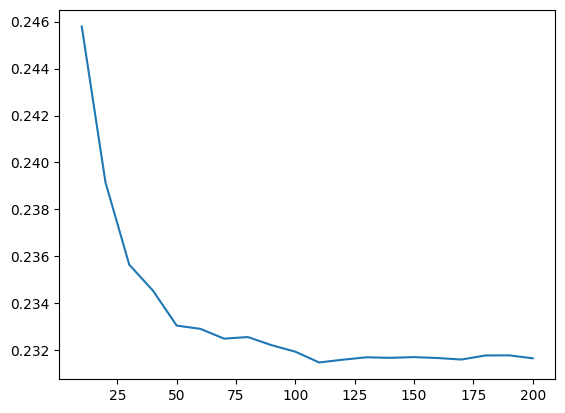

In [11]:
#@ INSPECTING THE RMSE SCORES:
xs = [sc[0] for sc in res]
ys = [sc[1] for sc in res]

plt.plot(xs, ys)
plt.show()

- After which value of `n_estimators` does RMSE stop improving? (10, 50, 75 or 150)

- Answer: 

150

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [12]:
#@ TRAINING THE MODEL WITH DEPTH:
res = []
depths = [10, 15, 20, 25]
for depth in depths:
    for est in tqdm(range(10, 201, 10)):
        model_rf = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=1, n_jobs=-1)
        model_rf.fit(X_train, y_train)

        y_pred = model_rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        res.append((depth, est, rmse))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.93s/it]


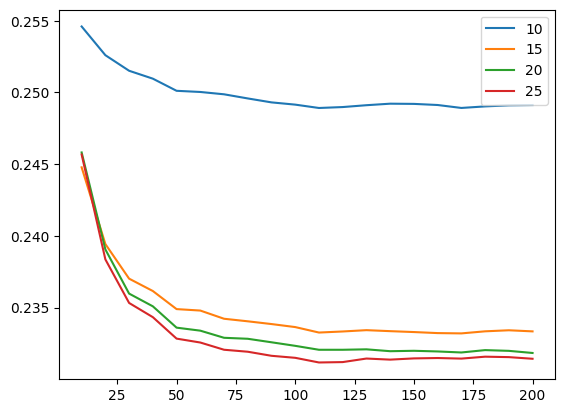

In [14]:
for depth in depths:
    xs = [sc[1] for sc in res if sc[0]==depth]
    ys = [sc[2] for sc in res if sc[0]==depth]

    plt.plot(xs, ys, label=depth)

plt.legend()
plt.show()

- What's the best `max_depth`:

- Answer:

25

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [15]:
#@ TRAINING THE RANDOM FOREST MODEL:
model_rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
model_rf.fit(X_train, y_train)
fi = model_rf.feature_importances_

In [16]:
dv.get_feature_names_out()[np.where(fi == max(fi))[0][0]]

'median_income'

- What's the most important feature?

- Answer:

median_income

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [17]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [18]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [19]:
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [20]:
%%capture output
model_xgb = xgb.train(xgb_params, dtrain=dtrain, evals=watchlist, verbose_eval=5, num_boost_round=100)

In [21]:
e03 = parse_xgb_output(output)

In [22]:
xgb_params = {  
    'eta': 0.1,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [23]:
%%capture output
model_xgb = xgb.train(xgb_params, dtrain=dtrain, evals=watchlist, verbose_eval=5, num_boost_round=100)

In [24]:
e01 = parse_xgb_output(output)

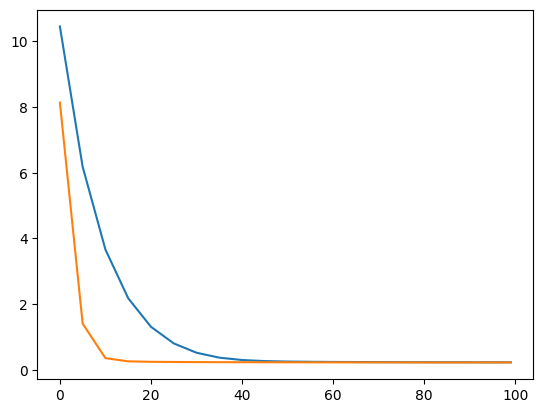

In [25]:
plt.plot(e01.num_iter, e01.val_rmse, label='eta=0.1')
plt.plot(e01.num_iter, e03.val_rmse, label='eta=0.3')
plt.show()

- Which eta leads to the best RMSE score on the validation dataset?

- Answer:

0.3